# RNN 모델링

## 불용어 제거 및 차원 지정

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from eunjeon import Mecab
import re
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

In [3]:
data = pd.read_csv('./trainset.csv', encoding='utf-8')
x=data['contents']
y=data['id']

# 형태소 분석

In [4]:
tagger = Mecab()
x_data = []
for s in x:
    morph_tokenized_sentences = tagger.morphs(s)
    x_data.append(morph_tokenized_sentences)


In [21]:
# tagger = Mecab()
# morph_tokenized_sentences = [tagger.morphs(s.replace(' ', '')) for s in x]
# morph_tokenized_sentences

# 특수기호 제거

In [5]:
temp=[]
for j in range(len(x_data)):
    for document in x_data[j]:
        temp.append(re.sub(r'[^ ㄱ-ㅣ가-힣A-Za-z]', '', document))  
    x_data[j] = temp
    temp=[]

# 불용어 제거

In [6]:
stopwords = []
f = open('./불용어사전.txt',encoding='UTF8')
lines = f.readlines()
for line in lines:
    line = line.strip()
    stopwords.append(line)
f.close()


X_data=[]
for w in x_data:
    temp_X = [t for t in w if not t in stopwords]
    X_data.append(temp_X)
X_data[0]    

['어서',
 '세요',
 '코디',
 '봇',
 '도와드릴까요',
 '처음',
 '대학교',
 '들어가',
 '는',
 '옷',
 '코디',
 '해',
 '세요',
 '신입',
 '생',
 '코디',
 '어울리',
 '게',
 '화사',
 '스웨터',
 '추천',
 '해',
 '드릴게요',
 '옷',
 '어울리',
 '는',
 '치마',
 '추천',
 '해',
 '세요',
 '라운드',
 '네크라인',
 '밈',
 '는',
 '풀오버',
 '스타일',
 '전체',
 '케이블',
 '조직',
 '드롭',
 '숄더',
 '슬리브',
 '손등',
 '는',
 '길이',
 '소매',
 '몸',
 '적당히',
 '맞',
 '는',
 '품',
 '엉덩이',
 '덮',
 '는',
 '길',
 '네크라인',
 '소매',
 '끝',
 '밑단',
 '고무단',
 '처리',
 '레이온',
 '나일론',
 '폴리에스터',
 '꽈배기',
 '조직',
 '플레인',
 '조직',
 '섞여',
 '는',
 '형태',
 '드라이',
 '크리',
 '닝',
 '단색',
 '라임색',
 '브라이트',
 '톤',
 '고명',
 '도',
 '고채',
 '도',
 '옐로우',
 '그린',
 '산뜻',
 '고',
 '발랄',
 '기본',
 '단정',
 '편안',
 '산뜻',
 '발랄',
 '경쾌',
 '따뜻',
 '데일리',
 '룩',
 '캠퍼스',
 '룩']

# 1. 임베딩 레이어 활용

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

In [8]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6662
등장 빈도가 3번 이하인 희귀 단어의 수: 464
단어 집합에서 희귀 단어의 비율: 6.9648754127889525
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.015941076467683286


In [9]:
vocab_size = total_cnt - rare_cnt + 1 # tokenizer 함수에 들어 갈 때 영향줘서 1 추가 해야 됨
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6199


In [10]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_data)
X_data = tokenizer.texts_to_sequences(X_data)

문장 최대 길이 : 406
문장의 평균 길이 : 147.8651801281894


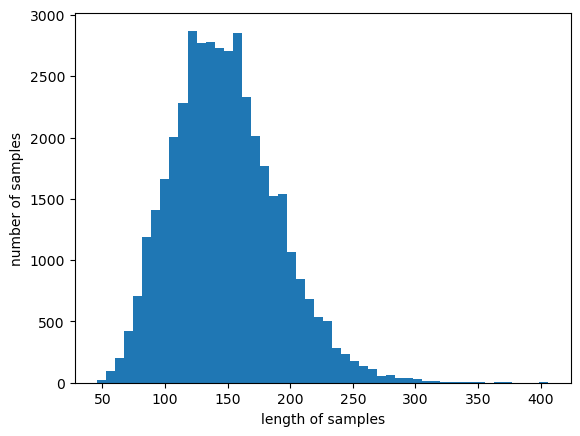

In [11]:
import matplotlib.pyplot as plt
print('문장 최대 길이 :',max(len(l) for l in X_data))
print('문장의 평균 길이 :',sum(map(len, X_data))/len(X_data))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
plt.close()

In [12]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 250
below_threshold_len(max_len, X_data)

전체 샘플 중 길이가 250 이하인 샘플의 비율: 98.4921784828467


# padding

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_data = pad_sequences(X_data, maxlen = max_len)
enc = LabelEncoder()
enc.fit(y)
Y_label = enc.transform(y)
y_data = tf.keras.utils.to_categorical(Y_label)

# RNN 모델

In [14]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.3, random_state=777, stratify=y_data)
x_train.shape

(28504, 250)

In [16]:
type(y_test)

numpy.ndarray

In [36]:
# import numpy as np
# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [17]:
x_train.shape

(28504, 250)

In [18]:
y_train.shape

(28504, 13)

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, max_len))
model.add(SimpleRNN(250))
model.add(Dense(13, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 250)         1549750   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 250)               125250    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                3263      
Total params: 1,678,263
Trainable params: 1,678,263
Non-trainable params: 0
_________________________________________________________________


In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('total_category_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_split=0.2)

loaded_model = load_model('total_category_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)))

Epoch 1/10
713/713 [==============================] - 108s 150ms/step - loss: 0.5481 - acc: 0.8453 - val_loss: 0.1027 - val_acc: 0.9768

Epoch 00001: val_acc improved from -inf to 0.97685, saving model to total_category_model.h5
Epoch 2/10
713/713 [==============================] - 103s 144ms/step - loss: 0.0557 - acc: 0.9874 - val_loss: 0.0978 - val_acc: 0.9732

Epoch 00002: val_acc did not improve from 0.97685
Epoch 3/10
713/713 [==============================] - 105s 148ms/step - loss: 0.7774 - acc: 0.7561 - val_loss: 1.9018 - val_acc: 0.3875

Epoch 00003: val_acc did not improve from 0.97685
Epoch 4/10
713/713 [==============================] - 163s 229ms/step - loss: 1.5394 - acc: 0.5126 - val_loss: 0.9432 - val_acc: 0.6865

Epoch 00004: val_acc did not improve from 0.97685
Epoch 5/10
713/713 [==============================] - 122s 172ms/step - loss: 0.6317 - acc: 0.7963 - val_loss: 0.3872 - val_acc: 0.8716

Epoch 00005: val_acc did not improve from 0.97685
Epoch 6/10
713/713 [===

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


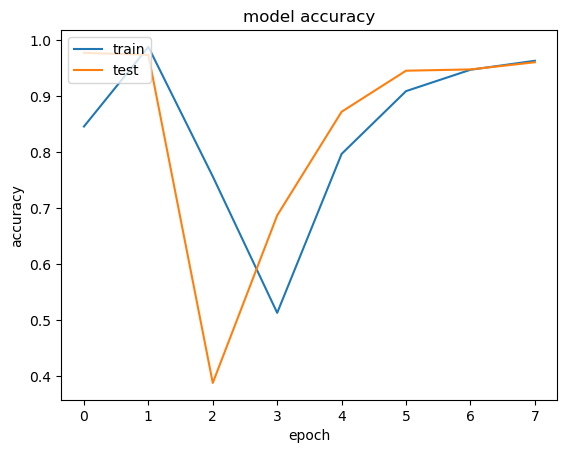

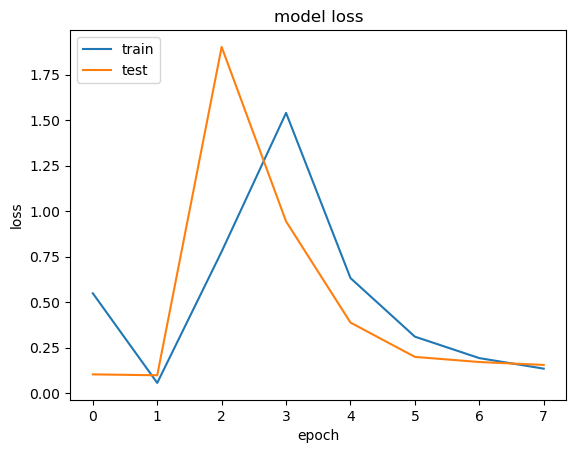

In [23]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()